## <i>ENGG67 - REDES NEURAIS ARTIFICIAIS</i>
**Universidade Federal da Bahia** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Semestre:** 2024.2 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Data:** 03/12/2024  
**Disciplina:** ENGG67 - Tópicos Especiais em Engenharia da Computação &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
**Docente:** Antonio C. L. Fernandes Jr. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Integrantes:** David Oliveira e André Costa  

**3° AVALIAÇÃO:**  
Escolha uma tarefa de classificação ou regressão que possa ser abordada utilizando MLPs. Selecione um banco de dados adequado (sugestões em https://archive.ics.uci.edu/). Projete e treine uma rede MLP de duas camadas para resolver a tarefa pretendida. Utilize o método de validação cruzada k-fold para avaliar o treinamento do modelo.

Este notebook aborda a implementação de um modelo MLP para classificação de dígitos escritos de forma manuscrita usando o conjunto de dados **[Optical Recognition of Handwritten Digits](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)**. O fluxo do trabalho inclui análise dos dados, pré-processamento, divisão em conjuntos de treino e teste, validação cruzada para avaliação robusta do modelo, análise de desempenho no conjunto de teste e, por fim, a visualização dos resultados obtidos.


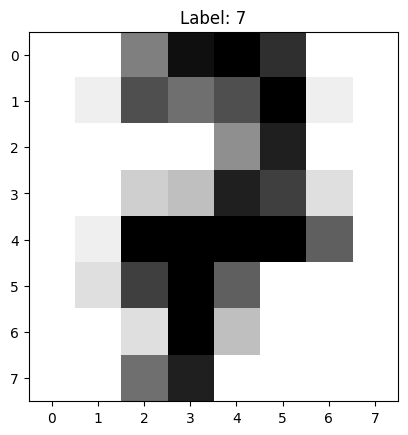

In [1]:
# Importando as bibliotecas necessárias.
from ucimlrepo import fetch_ucirepo

from SimplesMLP import *
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

from treinador import *
  
# Importando o conjunto de dados.
digits = fetch_ucirepo(id=80) 
x = digits.data.features
y = digits.data.targets

# Exibindo uma amostra do conjunto de dados.
plt.imshow(x.iloc[2].values.reshape(8,8), cmap='binary')
plt.title(f'Label: {y.iloc[2].values[0]}')
plt.show()

# Verifica se o dispositivo CUDA está disponível.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Análise do conjunto de dados**  

Vamos aproveitar os códigos desenvolvidos nas primeiras atividades para realizar uma análise rápida sobre o conjunto de dados escolhido para esta avaliação. Abordaremos, por exemplo, o número de atributos preditivos e rótulos presentes, os valores existentes em cada atributo, a presença de objetos com atributos ausentes, a existência de objetos duplicados entre outros aspectos. Como a analise de dados já foi tema dos trabalhos anteriores, aqui vamos ir direto as próximas etapas mas sempre lembrando da importância dessa etapa de conhecer os dados previamente para realizar processamentos visando melhorar o desempenho no treinamento. A seguir, detalharemos esses pontos:

In [2]:
# Exibir informações do conjunto de dados, lembrando que teremos 303 instâncias ou objetos.
printColorido("LISTA DOS ATRIBUTOS DO CONJUNTO DE DADOS:".upper(), "magenta", " ")
print(list(x.columns))
printColorido("QUANTIDADE DE ATRIBUTOS PREDITIVOS DO CONJUNTO DE DADOS:", "magenta", ' ')
print(x.shape)
printColorido("QUANTIDADE DE RÓTULOS DO CONJUNTO DE DADOS:", "magenta", ' ')
print(y.shape)

# Verificando o balanceamento das classes
classes = contarClasses(y) # Retorna um dicionario com a contagem do número classes.
printColorido("\nDistribuição das classes dos rótulos inicialmente:".upper(), "magenta")
for classe in sorted(classes.keys()):
    printColorido(f'DÍGITO {classe}: ', end='', color='yellow')
    print(f'{round(classes[classe]*100/x.shape[0], 2)}%   ', end='')

printColorido("\n\nVISUALIZAÇÃO DOS OBJETOS COM INCOMPLETUDE:".upper(), "magenta")
incompletos = obterIncompletude(x) # Procura, e exibe, quantos dados estão faltando.

printColorido("\nVISUALIZAÇÃO DOS OBJETOS COM REPETIÇÕES:".upper(), "magenta")
duplicados = obterRedundancias(x) # Encontrar as linhas duplicadas.

LISTA DOS ATRIBUTOS DO CONJUNTO DE DADOS: ['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5', 'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14', 'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18', 'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30', 'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34', 'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38', 'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42', 'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46', 'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50', 'Attribute51', 'Attribute52', 'Attribute53', 'Attribute54', 'Attribute55', 'Attribute56', 'Attribute57', 'Attribute58', 'Attribute59', 'Attribute60', 'Attribute61', 'Attribute62', 'Attribute63', 'Attribute64']
QUANTI

**Conversão para tensores e Divisão dos Dados**  

Optamos por realizar o trabalho usando a biblioteca PyTorch, por isso os dados precisam ser convertidos para tensores. Os tensores são usados no PyTorch porque são a estrutura de dados principal para realizar operações matemáticas e computacionais eficientes, especialmente no treinamento de modelos de aprendizado de máquina e deep learning. 

Os dados também foram divididos usando `train_test_split`:  
- `test_size=0.2`: Define 20% dos dados para teste.  
- `random_state=42`: Garante reprodutibilidade.  

Teremos então que 80% dos dadoas seráo usados para treinamento usando a validação cruzada, enquanto 20% dos dados foram separados completamente da etapa de treino para testar o modelo no final.


In [3]:
xTensor = torch.tensor(x.values, dtype=torch.float32) # Convertendo para tensor.
yTensor = torch.tensor(y.values.flatten(), dtype=torch.long) 

# Divisão inicial dos dados em treino e teste.
xFold, xTeste, yFold, yTeste = train_test_split(xTensor, yTensor, test_size=0.2, random_state=42)

**Treinamento usando validação Cruzada com K-Fold**  

A validação cruzada K-Fold com 5 partições foi utilizada para avaliar o desempenho do modelo de forma consistente e minimizar o risco de overfitting. Nesse processo, os dados de treino foram divididos em 5 partes iguais. A cada iteração, uma parte foi usada como conjunto de validação e as outras quatro como conjunto de treinamento. Essa abordagem garante que cada dado seja usado tanto para treino quanto para validação, promovendo uma avaliação mais robusta.

As métricas utilizadas foram definidas pelas seguintes fórmulas:
&nbsp;  
$$
ACC = \frac{TP + TN}{TP + TN + FP + FN}, \quad Precision = \frac{TP}{TP + FP}, \quad Recall = \frac{TP}{TP + FN}, \quad F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$
&nbsp;
- **TP (True Positive / Verdadeiro Positivo)**: Instâncias corretamente classificadas como positivas.
- **TN (True Negative / Verdadeiro Negativo)**: Instâncias corretamente classificadas como negativas.
- **FP (False Positive / Falso Positivo)**: Instâncias incorretamente classificadas como positivas.
- **FN (False Negative / Falso Negativo)**: Instâncias incorretamente classificadas como negativas.

Ao final das iterações, foram computadas as médias e os desvios padrão dessas métricas, refletindo o desempenho geral do modelo.


A cada fold, os dados foram divididos em conjuntos de treino e validação de acordo com os índices gerados pelo K-Fold. O modelo utilizado foi uma rede neural simples ajustada para o problema em questão, com uma arquitetura configurada para o número de canais de entrada e classes do dataset.

Para otimizar o treinamento, foi utilizada a função de perda `CrossEntropyLoss`, adequada para problemas de classificação, e o otimizador `Adam`, conhecido por sua eficiência em treinamento de redes neurais. Além disso, um scheduler foi implementado para reduzir a taxa de aprendizado de forma dinâmica sempre que a métrica de validação estagnasse.

Os dados também foram organizados em DataLoaders para facilitar o processamento em lotes durante o treinamento e validação. Isso permite que o modelo treinede forma eficiente, mesmo com um grande volume de dados.


Para cada fold, as métricas calculadas foram armazenadas em uma estrutura apropriada, permitindo a análise detalhada do desempenho ao final do processo. Além disso, os pesos do modelo de cada fold foram salvos em uma pasta específica, possibilitando a recuperação ou reutilização desses modelos no futuro.


In [4]:
# Algumas configurações importantes:
k = 5                                                                          # Número de folds.
lr = 1e-4                                                                      # Taxa de aprendizado.
wDecay = 1e-3                                                                  # Peso da penalização L2.
batchSize = 200                                                                # Tamanho do lote.
numMaxEpocas = 2000                                                            # Número máximo de épocas.

# Definição a validação cruzada.
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Cria uma pasta para salvar cada fold.
pasta = Path("weights")
pasta.mkdir(parents=True, exist_ok=True)

fold = 1
foldMetrics = [] # Listas para armazenar as métricas de cada fold.
for treinoIndices, valIndices in kf.split(xFold): # K-Fold Validação cruzada.
    printColorido(f"==================================================== FOLD {fold} ====================================================", 'magenta')

    # Definindo a arquitetura da rede neural.
    model = SimplesMLP(inputChannels=x.shape[1], numClasses=len(classes.keys())).to(device)
    
    criterion = nn.CrossEntropyLoss()                                             # Função de perda.
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wDecay)         # Otimizador.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',  patience=10, factor = 0.5) # Reduz a taxa de aprendizado de forma dinâmica.
    
    # Dividindo os dados entre treinamento e validação.
    xTreino, xVal, yTreino, yVal = xTensor[treinoIndices], xTensor[valIndices], yTensor[treinoIndices], yTensor[valIndices]
    
    # Definindo os conjuntos de dados e os carregadores de dados.
    treinoDs, valDs = TensorDataset(xTreino, yTreino), TensorDataset(xVal, yVal)
    treinoLoader, valLoader = DataLoader(treinoDs, batch_size=batchSize, shuffle=True), DataLoader(valDs, batch_size=batchSize)
    model, metricas = treinador(fold, model, criterion, optimizer, scheduler, [treinoLoader, valLoader], device, numMaxEpocas)
    foldMetrics.extend([metricas])
    
    fold += 1
    

==================================================== FOLD 1 ====================================================
--------------------------------------------------- ÉPOCA 1 ----------------------------------------------------
TREINAMENTO:    LOSS: 2.5569   ACCURACY: 17.54%   F-1: 12.75%   PRECISÃO: 12.92%   RECALL: 17.54%   TEMPO: 0.28s
TREINAMENTO:    LOSS: 2.0597   ACCURACY: 27.87%   F-1: 22.25%   PRECISÃO: 21.72%   RECALL: 27.87%   TEMPO: 0.02s
--------------------------------------------------- ÉPOCA 2 ----------------------------------------------------
TREINAMENTO:    LOSS: 2.1978   ACCURACY: 23.84%   F-1: 21.72%   PRECISÃO: 21.53%   RECALL: 23.84%   TEMPO: 0.09s
TREINAMENTO:    LOSS: 1.7916   ACCURACY: 45.89%   F-1: 43.65%   PRECISÃO: 45.54%   RECALL: 45.89%   TEMPO: 0.02s
--------------------------------------------------- ÉPOCA 3 ----------------------------------------------------
TREINAMENTO:    LOSS: 1.8981   ACCURACY: 33.54%   F-1: 31.97%   PRECISÃO: 32.22%   RECALL: 33.54

**Análise dos Resultados dos Folds e Identificação do Melhor Modelo**  

Após o treinamento utilizando a validação cruzada com K-Fold, é necessário calcular as métricas médias e os desvios padrão para avaliar o desempenho geral do modelo em todos os folds. Além disso, identificamos o melhor fold com base no F1-Score, uma métrica robusta para modelos com classes desbalanceadas.

Para cada fold, as métricas de interesse (perda, acurácia, F1-Score, precisão e revocação) foram extraídas da melhor época de treinamento, armazenada em foldMetrics. Os valores correspondentes de cada métrica foram coletados em listas específicas (lossList, accList, etc.). Assim, as métricas médias e seus desvios padrão foram calculados a partir dos resultados de todos os folds. Isso fornece uma visão geral do desempenho do modelo durante a validação cruzada, incluindo a variabilidade de cada métrica.

Por fim, O fold com o maior F1-Score foi selecionado como o melhor modelo. Esse critério garante que o modelo escolhido seja aquele com o melhor equilíbrio entre precisão e revocação.

MÉDIA DAS MÉTRICAS DOS FOLDS:
PERDA: 0.0558 ± 0.0149    ACURÁCIA: 0.9857 ± 0.0040    PONTUAÇÃO F1: 0.9856 ± 0.0040    PRECISÃO: 0.9861 ± 0.0047    REVOCAÇÃO: 0.9857 ± 0.0040   

MÉTRICAS DO MELHOR FOLD:
PERDA: 0.0402    ACURÁCIA: 0.9907    PONTUAÇÃO F1: 0.9907    PRECISÃO: 0.9913    REVOCAÇÃO: 0.9907   
O melhor treinamento foi no fold de número 5

MÉTRICAS AO LONGO DAS ÉPOCAS DO MELHOR FOLD:


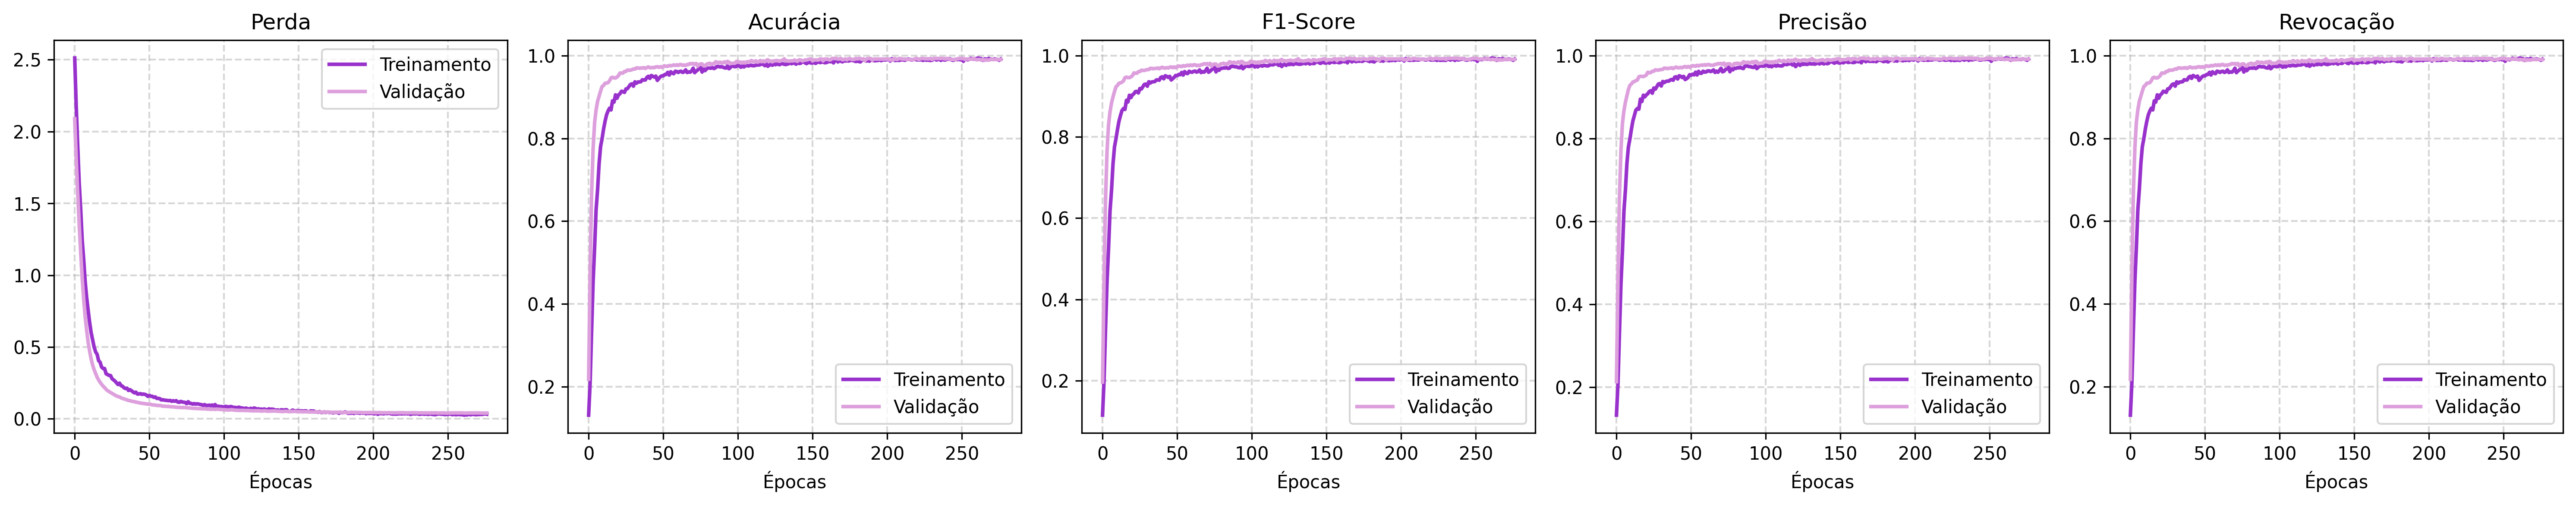

In [5]:
lossList, accList, f1List, precList, recList = [], [], [], [], []
for fold in range(k):
    melhorEpoca = foldMetrics[fold][2] - 1
    lossList.append(foldMetrics[fold][1][0][melhorEpoca])
    accList.append(foldMetrics[fold][1][1][melhorEpoca])
    f1List.append(foldMetrics[fold][1][2][melhorEpoca])
    precList.append(foldMetrics[fold][1][3][melhorEpoca])
    recList.append(foldMetrics[fold][1][4][melhorEpoca])

# Calculando a média de cada métrica, baseado nos resultados dos folds.
lossMean, accMean, f1Mean, precMean, recMean = (np.array(lossList).mean(), np.array(accList).mean(), np.array(f1List).mean(), np.array(precList).mean(), np.array(recList).mean())

# Calculando o desvio padrão de cada métrica, baseado nos resultados dos folds.
lossStd, accStd, f1Std, precStd, recStd = (np.array(lossList).std(), np.array(accList).std(), np.array(f1List).std(), np.array(precList).std(), np.array(recList).std())

printColorido("MÉDIA DAS MÉTRICAS DOS FOLDS:", 'magenta')
print(f"PERDA: {lossMean:.4f} ± {lossStd:.4f}   ", f"ACURÁCIA: {accMean:.4f} ± {accStd:.4f}   ", f"PONTUAÇÃO F1: {f1Mean:.4f} ± {accStd:.4f}   ", f"PRECISÃO: {precMean:.4f} ± {precStd:.4f}   ", f"REVOCAÇÃO: {recMean:.4f} ± {recStd:.4f}   ")

printColorido("\nMÉTRICAS DO MELHOR FOLD:", 'magenta')
melhorFold = f1List.index(max(f1List)) # Obtendo o melhor modelo, baseado no f-1 score de cada fold.
print(f"PERDA: {lossList[melhorFold]:.4f}   ", f"ACURÁCIA: {accList[melhorFold]:.4f}   ", f"PONTUAÇÃO F1: {f1List[melhorFold]:.4f}   ", f"PRECISÃO: {precList[melhorFold]:.4f}   ", f"REVOCAÇÃO: {recList[melhorFold]:.4f}   ")
printColorido(f'O melhor treinamento foi no fold de número {melhorFold + 1}', color='yellow')

printColorido("\nMÉTRICAS AO LONGO DAS ÉPOCAS DO MELHOR FOLD:", 'magenta')
plotarMetricas(foldMetrics[melhorFold])

**Avaliação do Modelo com os Dados de Teste**  

Após a identificação do melhor fold durante a validação cruzada, o modelo é carregado com os pesos correspondentes a esse fold. Em seguida, o desempenho do modelo é avaliado em um conjunto de dados de teste separado, que não foi usado nem no treinamento nem na validação.

In [6]:
 # Carregando o modelo com os pesos do melhor fold.
model = SimplesMLP(inputChannels=x.shape[1], numClasses=len(classes.keys())).to(device)
model.load_state_dict(torch.load(Path(f'weights/fold_{melhorFold+1}/weights.pth'), weights_only=True))

model.eval()  # Coloca o modelo no modo de avaliação
predicoes, rotulos = [], []
    
# Definindo os conjuntos de dados e o loader.
testeDs = TensorDataset(xTeste, yTeste)
testeLoader = DataLoader(testeDs, batch_size=batchSize, shuffle=False)

# Não precisamos calcular gradientes durante a avaliação
with torch.no_grad():
    for dado, lbl in testeLoader:
        dado, lbl = dado.to(device), lbl.to(device)
        
        ypred = model(dado) # Realizando a predição
        
        predicoes.append(ypred)
        rotulos.append(lbl)

# Concatena todas as predições e rótulos
predicoes, rotulos = torch.cat(predicoes, dim=0), torch.cat(rotulos, dim=0)

# Calcular as métricas usando a função já definida
acc, f1, prec, recall = calcularMetricas(predicoes, rotulos)

printColorido("MÉTRICAS DOS DADOS DE TESTE:", 'magenta')
print(f"ACURÁCIA: {acc:.4f}   ", f"PONTUAÇÃO F1: {f1:.4f}   ", f"PRECISÃO: {prec:.4f}   ", f"REVOCAÇÃO: {recall:.4f}   ")

inicio = 0

MÉTRICAS DOS DADOS DE TESTE:
ACURÁCIA: 0.9912    PONTUAÇÃO F1: 0.9909    PRECISÃO: 0.9907    REVOCAÇÃO: 0.9912   


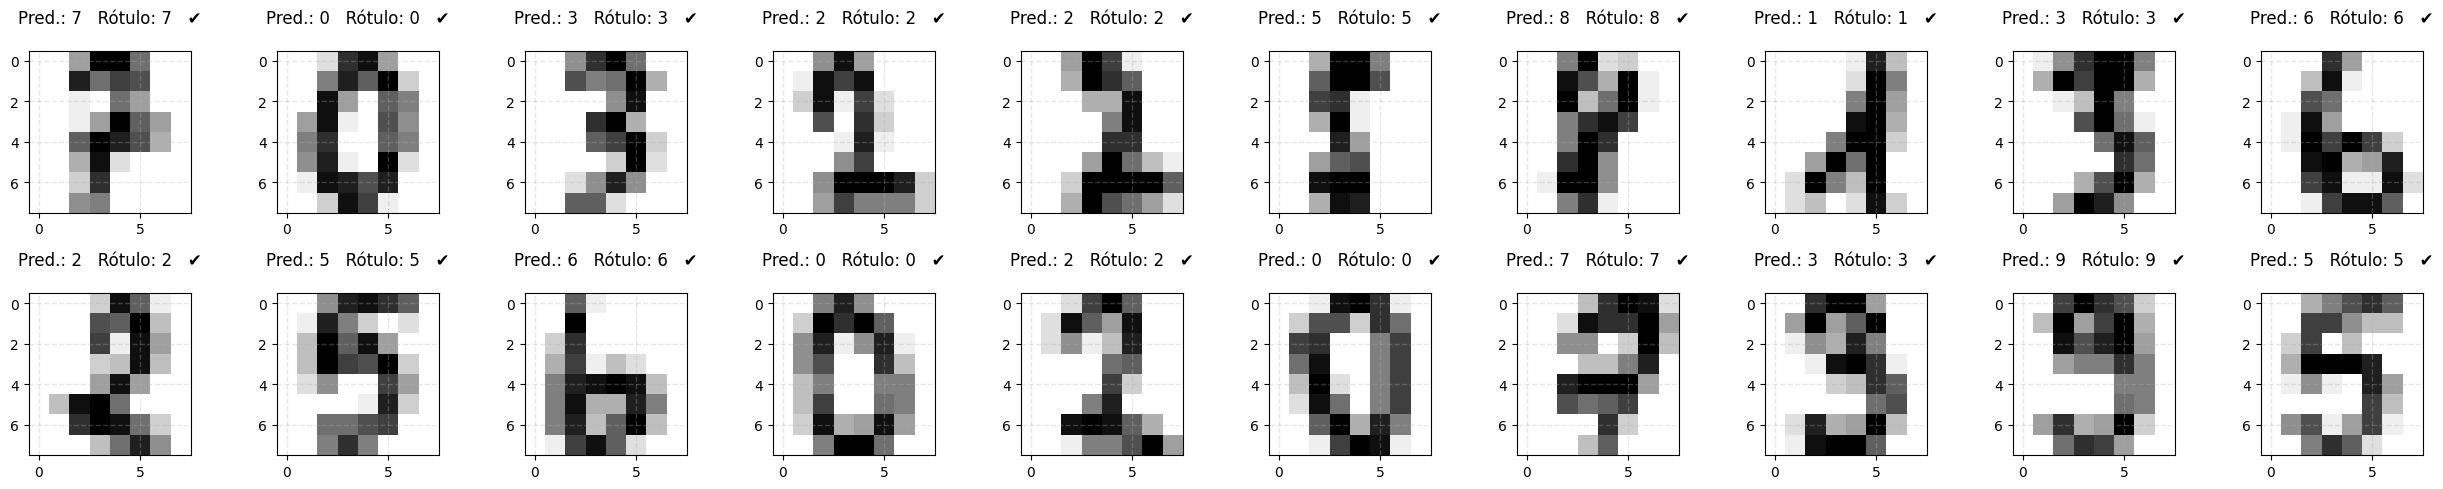

In [7]:
# Função para plotar as primeiras predições do conjunto de teste, podemos executar este bloco mais de uma vez que a função avança para as próximas predições.
numPlots = 20
plotarPredicoes(xTeste, predicoes, rotulos, numPlots=numPlots, inicio=inicio)
inicio += numPlots


**Visualização da Matriz de Confusão**  

A matriz de confusão é uma ferramenta importante para avaliar a performance do modelo de classificação, mostrando como as previsões se comparam com os rótulos reais. Ela nos permite entender onde o modelo acerta e onde ele comete erros, proporcionando uma visão detalhada de seu comportamento.


A matriz de confusão em problemas multiclasse é uma tabela que compara as classes reais com as previstas pelo modelo. Ela possui 𝑛 × 𝑛 células, onde 𝑛 é o número de classes. As `linhas representam as classes reais` enquanto `as colunas representam as classes previstas`.

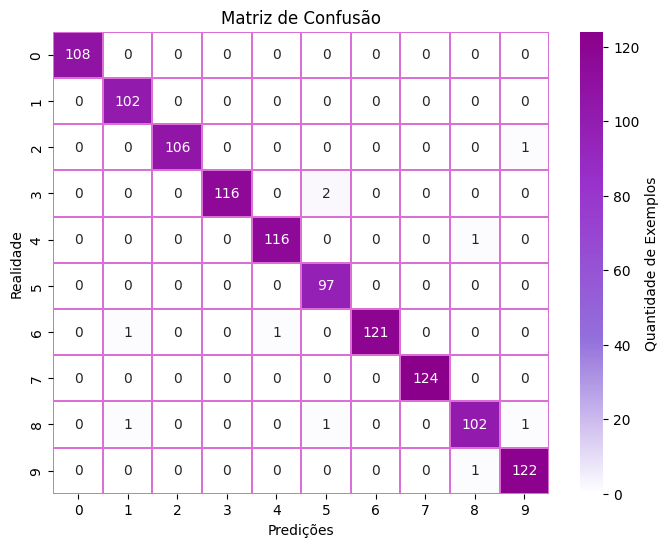

In [8]:
# Definir o colormap customizado.
colors = ['white', 'mediumpurple', 'darkorchid', 'darkmagenta']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
sortedClasses = sorted(classes.keys())

# Calcular a matriz de confusão.
cm = confusion_matrix(rotulos.cpu().numpy(), predicoes.argmax(dim=1).cpu().numpy(), labels=sortedClasses)

# Plotando a matriz de confusão.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, 
            xticklabels=sortedClasses, yticklabels=sortedClasses,
            cbar_kws={'label': 'Quantidade de Exemplos'},
            linewidths=0.1, linecolor='orchid')  # Adicionando bordas nos quadrados
plt.xlabel('Predições')
plt.ylabel('Realidade')
plt.title('Matriz de Confusão')
plt.show()


**Inferência de Imagens com Dígitos Manuscritos**  

Após o treinamento e a avaliação do modelo, ele pode ser utilizado para inferir dígitos manuscritos a partir de arquivos de imagem no formato `.png`. É importante observar que, como o modelo foi treinado em um conjunto de dados específico, os resultados podem ser inferiores ao esperado para imagens fora desse conjunto. Isso ocorre porque a caligrafia de cada indivíduo é única e o redimensionamento das imagens para 8x8 pixels pode comprometer a qualidade visual do dígito.  

Ainda assim, testar o modelo com diferentes dígitos manuscritos é uma experiência interessante, pois aproxima o trabalho de situações reais, onde as condições dos dados de entrada podem variar significativamente.  

A função de inferência foi projetada para aceitar imagens de qualquer tamanho. Durante o pré-processamento, as imagens são automaticamente redimensionadas para um tamanho fixo de **8x8 pixels**, compatível com os dados usados no treinamento. Essa abordagem elimina a necessidade de ajustes manuais e garante que o modelo possa lidar com entradas variadas, simplificando sua aplicação prática.  

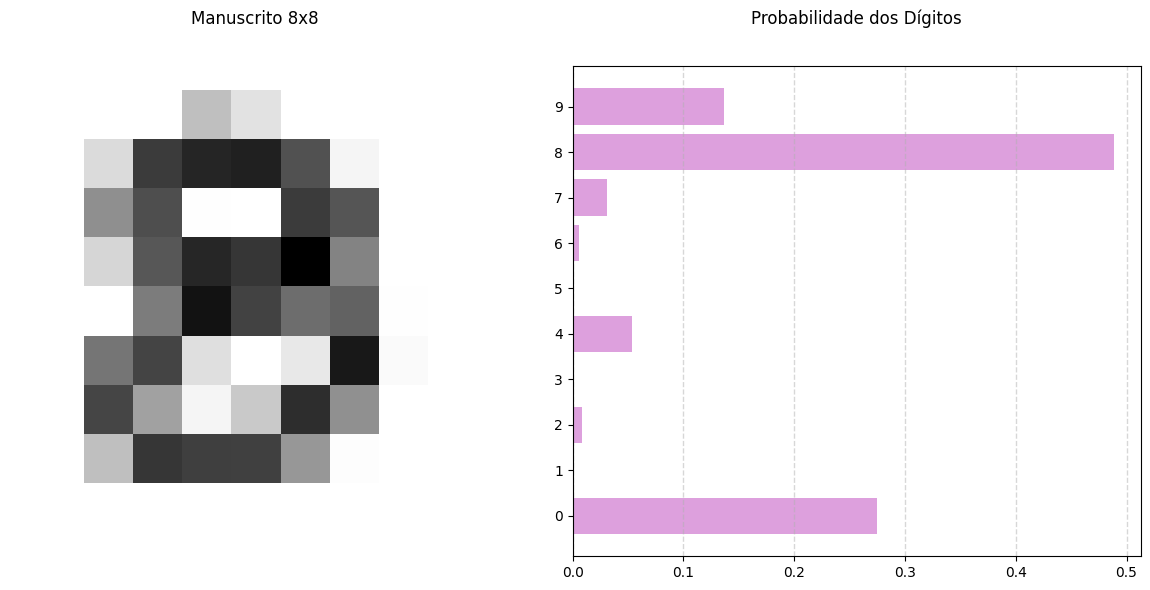

In [6]:
# Podemos agora inferir um PNG qualquer com um dígito manuscrito. A função pode receber imagens de qualquer tamanho, pois ela redimensiona a imagem para 8x8.
plotManuscritoComDígitos(Path('digits/digit-8.png'), Path(f'weights/fold_{5}/weights.pth'), device)